In [54]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm.notebook import tqdm as tqdm
from PIL import Image
import os
from pathlib import Path
from datetime import datetime
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [55]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device('cpu')

print(device)

cuda


In [56]:
save_dir = str(Path(fr"./runs/exp"))

In [57]:
num_workers = 8
batch_size = 16
epoch_num = 100

LR = 1e-4
EPS = 1e-9
LR_STEP = 20
LR_GAMMA = 0.7

In [58]:
class CustomImageDataset(Dataset):
    def __init__(self):
        self.data = pd.read_csv('data/train_in.csv').drop(['Serial No.'], axis=1)  # 從csv文件中讀取數據
        self.label = pd.read_csv('data/train_out.csv') # 從csv文件中讀取數據
        self.reshaped_data = torch.from_numpy(self.data.values.reshape(-1, 8, 2)).to(torch.float32)

    def __len__(self):
        return len(self.data)  # 返回數據集的大小

    def __getitem__(self, idx):
        data = self.reshaped_data[idx]
        label = torch.tensor(self.label.iloc[idx, 1], dtype=torch.long)
        return data, label  # 返回圖像和標籤

In [59]:
# 創建一個自定義的圖像數據集對象
dataset = CustomImageDataset()

# 計算訓練集的大小，通常是數據集的80%
train_size = int(0.8 * len(dataset))

# 驗證集的大小就是剩餘的部分
val_size = len(dataset) - train_size

# 使用random_split函數隨機分割數據集為訓練集和驗證集
train_dataset, valid_dataset = random_split(dataset, [train_size, val_size])

# 創建一個數據加載器的字典，對訓練集和驗證集分別進行加載
# shuffle參數設為True表示在每個訓練時期開始時，數據加載器會重新洗牌數據
dataloaders = {x: DataLoader(y, batch_size=batch_size, shuffle=z) 
               for x, y, z in zip(['train', 'valid'], [train_dataset, valid_dataset], [True, False])}

# 打印整個數據集的大小
print(len(dataset)) 


7494


In [7]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN 層
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # 全連接層，將 RNN 的輸出轉換為類別預測
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化隱藏狀態
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # 獲取 RNN 的輸出
        out, _ = self.rnn(x, h0)

        # 只需要最後一步的輸出給全連接層
        out = out[:, -1, :]

        # 通過全連接層獲得最終的類別預測
        out = self.fc(out)

        return out

In [8]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM 層
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # 全連接層，將 LSTM 的輸出轉換為類別預測
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化隱藏狀態和 cell 狀態
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # 獲取 LSTM 的輸出
        out, _ = self.lstm(x, (h0, c0))

        # 只需要最後一步的輸出給全連接層
        out = out[:, -1, :]

        # 通過全連接層獲得最終的類別預測
        out = self.fc(out)

        return out


In [60]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 將RNN換成GRU
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

        # 全連接層，將 GRU 的輸出轉換為類別預測
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化隱藏狀態
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # 獲取 GRU 的輸出
        out, _ = self.gru(x, h0)

        # 只需要最後一步的輸出給全連接層
        out = out[:, -1, :]

        # 通過全連接層獲得最終的類別預測
        out = self.fc(out)

        return out


In [63]:
# model_name =  RNNModel
# model_name =  LSTMModel
model_name =  GRUModel

model_kwargs = {
    'input_size': 2,    # 輸入的特徵維度
    'hidden_size': 64,  # 隱藏層的大小 
    'output_size': 10,  # 輸出的類別數量
    'num_layers': 5,    # RNN 的層數
}


# 建立模型
# model = RNNModel(**model_kwargs)
# model = LSTMModel(**model_kwargs)
model = GRUModel(**model_kwargs)

# 選擇優化器，使用AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, eps=EPS)
# 使用SGD作為優化器
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# 使用ReduceLROnPlateau學習率調度器，當某指標停止改進時，減少學習率
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                          mode='min', 
                                                          factor=0.5, 
                                                          patience=30, 
                                                          verbose=True, 
                                                          threshold=0.0001, 
                                                          threshold_mode='rel', 
                                                          cooldown=50, 
                                                          min_lr=0, 
                                                          eps=EPS)

# 使用ReduceLROnPlateau學習率調度器，當epoch計數器到一定值後會更先學習率
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP, gamma=LR_GAMMA)

# 選擇損失函數，這裡我們使用交叉熵損失函數
criterion = nn.CrossEntropyLoss()


In [64]:
# 導入ptflops庫，用於獲取模型的複雜度信息
from ptflops import get_model_complexity_info

# 指定使用第一塊GPU（索引為0）
with torch.cuda.device(0):
    # 獲取模型的複雜度信息，包括MACs和參數數量
    macs, params = get_model_complexity_info(model, (8, 2), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
    # 打印模型的計算複雜度（MACs）
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    # 打印模型的參數數量
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))


GRUModel(
  113.55 k, 100.000% Params, 921.74 KMac, 100.000% MACs, 
  (gru): GRU(112.9 k, 99.428% Params, 921.09 KMac, 99.929% MACs, 2, 64, num_layers=5, batch_first=True)
  (fc): Linear(650, 0.572% Params, 650.0 Mac, 0.071% MACs, in_features=64, out_features=10, bias=True)
)
Computational complexity:       921.74 KMac
Number of parameters:           113.55 k


In [65]:
ckpt = {
    'epoch': 0,
    'model_name': model_name,
    'model_args': model_kwargs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'criterion': criterion,
    'history': {
        'train_loss': [], 
        'valid_loss': [],
        'train_top1_accuracy': [], 
        'valid_top1_accuracy': [],
        'valid_loss_min': np.Inf,
        'train_loss_min': np.Inf,
        'best_acc': 0.0,
    },
    'readme': "",
    'date': datetime.now().isoformat(),
}

In [66]:
def increment_path(path, exist_ok=False, sep='', mkdir=False):
    # 增加文件或目錄路徑，例如將 runs/exp 變成 runs/exp{sep}2, runs/exp{sep}3, ... 等等。
    path = Path(path)  # 使路徑符合作業系統

    if path.exists() and not exist_ok:
        # 如果路徑存在且不允許重複，則進行增量操作
        path, suffix = (path.with_suffix(''), path.suffix) if path.is_file() else (path, '')

        for n in range(2, 9999):
            p = f'{path}{sep}{n}{suffix}'  # 增加路徑
            if not os.path.exists(p):  # 如果新路徑不存在，則跳出迴圈
                break
        path = Path(p)  # 將新路徑轉換為 Path 物件

    if mkdir:
        # 如果 mkdir 為 True，則創建新目錄
        path.mkdir(parents=True, exist_ok=True)  

    return str(path)  # 返回字符串形式的路徑

In [67]:
def train(ckpt, 
          save_dir, 
          model, 
          dataloaders, 
          optimizer, 
          lr_scheduler=None,
          num_epochs=100,
          dtype=torch.float32, 
          device='cpu'):

    # 將儲存目錄轉換為 Path 物件
    save_dir = Path(save_dir)
    # 使用 increment_path 增加儲存目錄的路徑，避免複寫先前資料
    save_dir = increment_path(
        Path(save_dir), exist_ok=(False if ckpt['epoch'] == 0 else True), mkdir=True)

    # 將模型移動到指定的裝置上，同步model的資料型別(要跟data 相同，不然會報錯)
    model = model.to(dtype=dtype).to(device)

    # 以存檔來初始化模型、優化器、學習率調度器和損失函數，如果程式碼意外停止，也能以ckpt來繼續訓練
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    if (lr_scheduler):
        lr_scheduler.load_state_dict(ckpt['lr_scheduler_state_dict'])
    criterion = ckpt['criterion']

    # 開始訓練循環
    for epoch in range(1, num_epochs + 1):

        # 初始化訓練和驗證的損失和準確率
        train_loss = 0.0
        valid_loss = 0.0
        train_top1 = 0.0
        valid_top1 = 0.0
        print(f"running epoch: {ckpt['epoch'] + 1}")

        # 設定模型為訓練模式
        model.train()
        for x, y in tqdm(dataloaders['train']):
            # 將優化器中的梯度清零
            optimizer.zero_grad()
            # 將輸入和標籤移動到指定的裝置上
            x = x.to(device)
            y = y.to(device)

            # 前向傳播，計算預測和損失
            predictions = model(x)
            loss = criterion(predictions, y)
            # 反向傳播，計算梯度
            loss.backward()
            # 使用優化器更新權重
            optimizer.step()

            # 累計訓練損失和準確率
            train_loss += loss.item() * x.size(0)
            train_top1 += torch.sum(torch.argmax(predictions, 1) == y).item()

        # 設定模型為驗證模式
        model.eval()
        with torch.no_grad():
            for x, y in tqdm(dataloaders['valid']):
                # 將輸入和標籤移動到指定的裝置上
                x = x.to(device)
                y = y.to(device)

                # 前向傳播，計算預測和損失
                predictions = model(x)
                loss = criterion(predictions, y)

                # 累計驗證損失和準確率
                valid_loss += loss.item() * x.size(0)
                valid_top1 += torch.sum(torch.argmax(predictions, 1) == y).item()

        # 如果有設置學習率調度器，則以驗證損失作為指標調整學習率
        if (lr_scheduler):
            lr_scheduler.step(valid_loss)

        # 計算訓練和驗證的平均損失和準確率
        train_loss = train_loss / len(dataloaders['train'].sampler)
        valid_loss = valid_loss / len(dataloaders['valid'].sampler)
        train_top1_acc = train_top1 / len(dataloaders['train'].sampler)
        valid_top1_acc = valid_top1 / len(dataloaders['valid'].sampler)

        # 將這一輪的訓練和驗證損失和準確率添加到歷史記錄中
        ckpt['history']['train_loss'].append(train_loss)
        ckpt['history']['valid_loss'].append(valid_loss)
        ckpt['history']['train_top1_accuracy'].append(train_top1_acc)
        ckpt['history']['valid_top1_accuracy'].append(valid_top1_acc)

        # 打印這一輪的訓練和驗證損失和準確率
        print(
            f'Train loss     -> {train_loss:.6f}      \
                Validation loss     -> {valid_loss:.6f}')
        print(
            f'Train top1 acc -> {train_top1_acc:.6f}      \
                Validation top1 acc -> {valid_top1_acc:.6f}')

        # 更新和保存檢查點信息
        ckpt['epoch'] += 1
        ckpt['model_state_dict'] = model.state_dict()
        ckpt['optimizer_state_dict'] = optimizer.state_dict()
        if (lr_scheduler):
            ckpt['lr_scheduler_state_dict'] = lr_scheduler.state_dict()
        ckpt['date'] = datetime.now().isoformat()

        # 如果驗證損失降低，則保存模型
        if valid_loss <= ckpt['history']['valid_loss_min']:
            print(
                f"Validation loss decreased ({ckpt['history']['valid_loss_min']:.6f} \
                    --> {valid_loss:.6f}).  Saving model ...")
            ckpt['history']['valid_loss_min'] = valid_loss
            torch.save(ckpt, str(Path(save_dir) / Path('valid_best.pth')))

        # 每10輪保存一次檢查點
        if (epoch) % 10 == 0:
            torch.save(ckpt, str(Path(save_dir) / Path(f'ckpt_{epoch}.pth')))
        torch.save(ckpt, str(Path(save_dir) / Path(f'last.pth')))

In [68]:
ckpt = train(ckpt, save_dir, model, dataloaders, optimizer, lr_scheduler=lr_scheduler, num_epochs=50, device=device)

running epoch: 1


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 1.978738                      Validation loss     -> 1.476231
Train top1 acc -> 0.329108                      Validation top1 acc -> 0.525684
Validation loss decreased (inf                     --> 1.476231).  Saving model ...
running epoch: 2


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 1.114403                      Validation loss     -> 0.885188
Train top1 acc -> 0.678065                      Validation top1 acc -> 0.753169
Validation loss decreased (1.476231                     --> 0.885188).  Saving model ...
running epoch: 3


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.723967                      Validation loss     -> 0.652791
Train top1 acc -> 0.802002                      Validation top1 acc -> 0.828552
Validation loss decreased (0.885188                     --> 0.652791).  Saving model ...
running epoch: 4


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.542493                      Validation loss     -> 0.500258
Train top1 acc -> 0.859049                      Validation top1 acc -> 0.866578
Validation loss decreased (0.652791                     --> 0.500258).  Saving model ...
running epoch: 5


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.418970                      Validation loss     -> 0.410343
Train top1 acc -> 0.891576                      Validation top1 acc -> 0.891261
Validation loss decreased (0.500258                     --> 0.410343).  Saving model ...
running epoch: 6


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.339558                      Validation loss     -> 0.340809
Train top1 acc -> 0.915930                      Validation top1 acc -> 0.909273
Validation loss decreased (0.410343                     --> 0.340809).  Saving model ...
running epoch: 7


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.279991                      Validation loss     -> 0.282888
Train top1 acc -> 0.927273                      Validation top1 acc -> 0.925951
Validation loss decreased (0.340809                     --> 0.282888).  Saving model ...
running epoch: 8


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.233129                      Validation loss     -> 0.251254
Train top1 acc -> 0.939450                      Validation top1 acc -> 0.933289
Validation loss decreased (0.282888                     --> 0.251254).  Saving model ...
running epoch: 9


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.201114                      Validation loss     -> 0.219104
Train top1 acc -> 0.946622                      Validation top1 acc -> 0.939293
Validation loss decreased (0.251254                     --> 0.219104).  Saving model ...
running epoch: 10


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.172364                      Validation loss     -> 0.212048
Train top1 acc -> 0.954962                      Validation top1 acc -> 0.937959
Validation loss decreased (0.219104                     --> 0.212048).  Saving model ...
running epoch: 11


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.149763                      Validation loss     -> 0.183815
Train top1 acc -> 0.961635                      Validation top1 acc -> 0.946631
Validation loss decreased (0.212048                     --> 0.183815).  Saving model ...
running epoch: 12


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.133641                      Validation loss     -> 0.178338
Train top1 acc -> 0.964971                      Validation top1 acc -> 0.945964
Validation loss decreased (0.183815                     --> 0.178338).  Saving model ...
running epoch: 13


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.118389                      Validation loss     -> 0.166991
Train top1 acc -> 0.968641                      Validation top1 acc -> 0.953969
Validation loss decreased (0.178338                     --> 0.166991).  Saving model ...
running epoch: 14


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.109256                      Validation loss     -> 0.138994
Train top1 acc -> 0.970809                      Validation top1 acc -> 0.962642
Validation loss decreased (0.166991                     --> 0.138994).  Saving model ...
running epoch: 15


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.099564                      Validation loss     -> 0.135532
Train top1 acc -> 0.972477                      Validation top1 acc -> 0.957305
Validation loss decreased (0.138994                     --> 0.135532).  Saving model ...
running epoch: 16


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.087740                      Validation loss     -> 0.124501
Train top1 acc -> 0.977982                      Validation top1 acc -> 0.965977
Validation loss decreased (0.135532                     --> 0.124501).  Saving model ...
running epoch: 17


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.081263                      Validation loss     -> 0.112892
Train top1 acc -> 0.978315                      Validation top1 acc -> 0.969313
Validation loss decreased (0.124501                     --> 0.112892).  Saving model ...
running epoch: 18


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.071395                      Validation loss     -> 0.122909
Train top1 acc -> 0.981985                      Validation top1 acc -> 0.966644
running epoch: 19


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.069977                      Validation loss     -> 0.105064
Train top1 acc -> 0.980651                      Validation top1 acc -> 0.972648
Validation loss decreased (0.112892                     --> 0.105064).  Saving model ...
running epoch: 20


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.059848                      Validation loss     -> 0.099101
Train top1 acc -> 0.984987                      Validation top1 acc -> 0.972648
Validation loss decreased (0.105064                     --> 0.099101).  Saving model ...
running epoch: 21


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.056366                      Validation loss     -> 0.097398
Train top1 acc -> 0.984654                      Validation top1 acc -> 0.971981
Validation loss decreased (0.099101                     --> 0.097398).  Saving model ...
running epoch: 22


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.056792                      Validation loss     -> 0.082353
Train top1 acc -> 0.984320                      Validation top1 acc -> 0.979987
Validation loss decreased (0.097398                     --> 0.082353).  Saving model ...
running epoch: 23


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.045735                      Validation loss     -> 0.092792
Train top1 acc -> 0.989658                      Validation top1 acc -> 0.971314
running epoch: 24


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.053309                      Validation loss     -> 0.079434
Train top1 acc -> 0.985154                      Validation top1 acc -> 0.978652
Validation loss decreased (0.082353                     --> 0.079434).  Saving model ...
running epoch: 25


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.042532                      Validation loss     -> 0.081907
Train top1 acc -> 0.989158                      Validation top1 acc -> 0.977318
running epoch: 26


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.038756                      Validation loss     -> 0.079851
Train top1 acc -> 0.989158                      Validation top1 acc -> 0.976651
running epoch: 27


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.039451                      Validation loss     -> 0.076850
Train top1 acc -> 0.989491                      Validation top1 acc -> 0.977985
Validation loss decreased (0.079434                     --> 0.076850).  Saving model ...
running epoch: 28


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.036942                      Validation loss     -> 0.077953
Train top1 acc -> 0.990325                      Validation top1 acc -> 0.979320
running epoch: 29


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.034548                      Validation loss     -> 0.074421
Train top1 acc -> 0.992160                      Validation top1 acc -> 0.981321
Validation loss decreased (0.076850                     --> 0.074421).  Saving model ...
running epoch: 30


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.031432                      Validation loss     -> 0.078494
Train top1 acc -> 0.992661                      Validation top1 acc -> 0.979320
running epoch: 31


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.030167                      Validation loss     -> 0.086549
Train top1 acc -> 0.992661                      Validation top1 acc -> 0.975984
running epoch: 32


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.027497                      Validation loss     -> 0.076210
Train top1 acc -> 0.993828                      Validation top1 acc -> 0.980654
running epoch: 33


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.027434                      Validation loss     -> 0.064879
Train top1 acc -> 0.992661                      Validation top1 acc -> 0.982655
Validation loss decreased (0.074421                     --> 0.064879).  Saving model ...
running epoch: 34


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.024668                      Validation loss     -> 0.064070
Train top1 acc -> 0.994162                      Validation top1 acc -> 0.981988
Validation loss decreased (0.064879                     --> 0.064070).  Saving model ...
running epoch: 35


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.025367                      Validation loss     -> 0.066204
Train top1 acc -> 0.993995                      Validation top1 acc -> 0.981988
running epoch: 36


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.024933                      Validation loss     -> 0.061190
Train top1 acc -> 0.994162                      Validation top1 acc -> 0.981988
Validation loss decreased (0.064070                     --> 0.061190).  Saving model ...
running epoch: 37


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.021613                      Validation loss     -> 0.063926
Train top1 acc -> 0.995329                      Validation top1 acc -> 0.985991
running epoch: 38


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.022297                      Validation loss     -> 0.067973
Train top1 acc -> 0.994495                      Validation top1 acc -> 0.983322
running epoch: 39


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.019771                      Validation loss     -> 0.071838
Train top1 acc -> 0.995663                      Validation top1 acc -> 0.981988
running epoch: 40


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.019385                      Validation loss     -> 0.063505
Train top1 acc -> 0.996163                      Validation top1 acc -> 0.983322
running epoch: 41


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.019052                      Validation loss     -> 0.063417
Train top1 acc -> 0.996163                      Validation top1 acc -> 0.983322
running epoch: 42


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.017211                      Validation loss     -> 0.066540
Train top1 acc -> 0.995997                      Validation top1 acc -> 0.981988
running epoch: 43


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.018080                      Validation loss     -> 0.062973
Train top1 acc -> 0.995329                      Validation top1 acc -> 0.983322
running epoch: 44


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.018914                      Validation loss     -> 0.061009
Train top1 acc -> 0.995329                      Validation top1 acc -> 0.984656
Validation loss decreased (0.061190                     --> 0.061009).  Saving model ...
running epoch: 45


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.018120                      Validation loss     -> 0.074860
Train top1 acc -> 0.995496                      Validation top1 acc -> 0.981321
running epoch: 46


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.013966                      Validation loss     -> 0.055920
Train top1 acc -> 0.997665                      Validation top1 acc -> 0.985324
Validation loss decreased (0.061009                     --> 0.055920).  Saving model ...
running epoch: 47


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.012891                      Validation loss     -> 0.059273
Train top1 acc -> 0.997331                      Validation top1 acc -> 0.984656
running epoch: 48


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.012969                      Validation loss     -> 0.058909
Train top1 acc -> 0.997998                      Validation top1 acc -> 0.985991
running epoch: 49


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.018537                      Validation loss     -> 0.064240
Train top1 acc -> 0.995997                      Validation top1 acc -> 0.985991
running epoch: 50


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

Train loss     -> 0.012926                      Validation loss     -> 0.062215
Train top1 acc -> 0.996997                      Validation top1 acc -> 0.985991


In [10]:
ckpt = torch.load(str(Path(fr"./runs/exp4") / Path('valid_best.pth')))
model.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

Text(0, 0.5, 'acc')

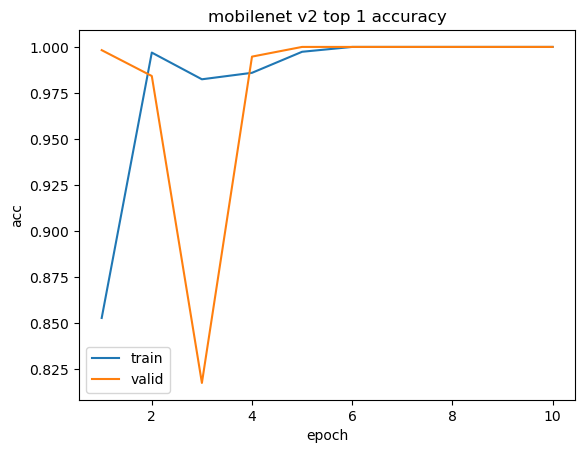

In [18]:
# 畫圖，只會畫前十個
# n = len(ckpt['history']['train_top1_accuracy'])
n = 10
epochs = range(1, n + 1)
plt.plot(epochs, ckpt['history']['train_top1_accuracy'][:n],label='train')
plt.plot(epochs, ckpt['history']['valid_top1_accuracy'][:n],label='valid')
# plt.xlim(50,)
# plt.ylim(0,0.1)
plt.legend()
plt.title('mobilenet v2 top 1 accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')


In [23]:
import os
import pandas as pd
import torch
from torchvision.transforms import ToTensor
from PIL import Image

def predict_and_save(model, folder_path, output_csv):
    # 創建一個將 PIL 圖片轉換為張量的轉換器
    transform = ToTensor()
    # 創建一個空的列表來保存結果
    results = []

    # 遍歷指定目錄下的所有文件
    for filename in os.listdir(folder_path):
        # 如果文件是 PNG 圖片
        if filename.endswith(".png"): 
            # 獲取圖片的完整路徑
            image_path = os.path.join(folder_path, filename)
            # 打開並將圖片轉換為 RGB
            image = Image.open(image_path).convert('RGB')
            # 將圖片轉換為張量並增加一個維度以匹配模型的輸入
            image_tensor = transform(image).unsqueeze(0)

            # 如果 CUDA 可用，則將模型和圖片張量移至 GPU
            if torch.cuda.is_available():  
                model = model.cuda()
                image_tensor = image_tensor.cuda()

            # 將模型設為評估模式
            model.eval()
            # 不計算梯度，因為這是推論，不需要反向傳播
            with torch.no_grad():
                # 進行預測
                prediction = model(image_tensor)
                # 從預測結果中獲取最大概率類別的索引
                category = prediction.argmax().item()
                # 將文件名和預測類別添加到結果列表中
                results.append((filename, category))

    # 將結果列表轉換為 DataFrame
    results_df = pd.DataFrame(results, columns=["filename", "category"])
    # 將結果 DataFrame 寫入 CSV 文件
    results_df.to_csv(output_csv, index=False)


# 使用方法
predict_and_save(model, "data/music_test", "output.csv")


In [11]:
import pandas as pd
import torch
from torch.utils.data import DataLoader

class TestDataset(Dataset):
    def __init__(self):
        self.data = pd.read_csv('data/test_in.csv')  # 從csv文件中讀取數據
        self.reshaped_data = torch.from_numpy(self.data.drop(['Serial No.'], axis=1).values.reshape(-1, 8, 2)).to(torch.float32)

    def __len__(self):
        return len(self.data)  # 返回數據集的大小

    def __getitem__(self, idx):
        data = self.reshaped_data[idx]
        serial_no = self.data.iloc[idx, 0]  # 讀取 Serial No.
        return data, serial_no

# 建立測試資料集與 DataLoader
test_dataset = TestDataset()
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()  # 將模型設為評估模式
result = []  # 用來儲存結果的list

with torch.no_grad():  # 不需要計算梯度，可以節省記憶體
    for data, serial_no in test_dataloader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)  # 預測出最大機率的類別
        result.append([serial_no.item(), predicted.item()])  # 將 Serial No. 與預測的類別加入 result list

# 將結果寫入 csv 文件
result_df = pd.DataFrame(result, columns=['Serial No.', 'Label'])
result_df.to_csv('runs/exp4/result.csv', index=False)


In [22]:
import pandas as pd

# 讀取兩個csv檔
df1 = pd.read_csv('data/result.csv')
df2 = pd.read_csv('runs/exp4/result.csv')

# 依照ID欄位合併兩個資料表
df = df1.merge(df2, on='Serial No.', suffixes=('_df1', '_df2'))
# print(df)
# 找出兩者欄位內容不同的地方
differences = df.compare(other=df)

column = 'Label'
# 建立一個空的 DataFrame 來儲存不同的欄位
df_diff = pd.DataFrame()
df_diff[column] = df[column + '_df1'] != df[column + '_df2']

# 列出所有存在不同的行
df[df_diff.any(axis=1)]

,Serial No.,Label_df1,Label_df2
52,53,5,9
130,131,6,4
135,136,1,7
167,168,1,3
191,192,9,5
...,...,...,...
3344,3345,3,9
3352,3353,1,7
3353,3354,9,3
3368,3369,1,5


In [50]:
data = pd.read_csv('data/test_in.csv')  # 從csv文件中讀取數據
reshaped_data = data.drop(['Serial No.'], axis=1).values.reshape(-1, 8, 2)
print(reshaped_data[0])

[[ 88  92]
 [  2  99]
 [ 16  66]
 [ 94  37]
 [ 70   0]
 [  0  24]
 [ 42  65]
 [100 100]]


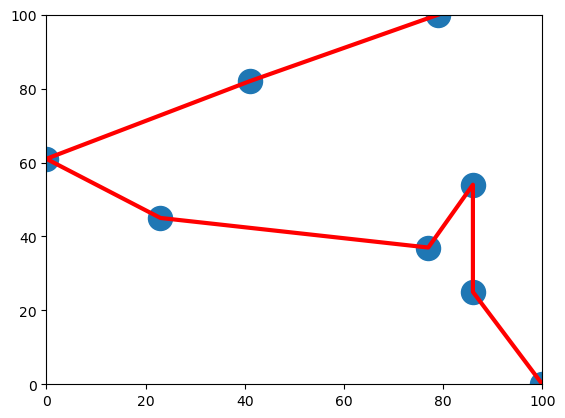

In [53]:
import matplotlib.pyplot as plt

# 假設你有8個座標點，每個點都有x和y兩個座標
points = reshaped_data[53]

# 分解為x座標和y座標
x = [point[0] for point in points]
y = [point[1] for point in points]

# 繪製座標點
plt.scatter(x, y, s=300)

# 繪製連接座標點的線
plt.plot(x, y, color='red', linewidth=3)

# 設定x軸和y軸的範圍
plt.xlim(0, 100)
plt.ylim(0, 100)

# 顯示圖表
plt.show()
